# Illustration of Various Kernels
---------------------------------

This function wll illustrate how to implement various kernels in TensorFlow.

Linear Kernel:

$$K(x_1, x_2) = x_1^{T} \cdot x_2$$

Gaussian Kernel (RBF):

$$K(x_1, x_2) = e^{(-\gamma |x_1 - x_2|^2)}$$

We start by loading the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Start a computational graph session:

In [2]:
sess = tf.Session()

For this example, we will generate fake non-linear data.  The data we will generate is concentric ring data.

In [3]:
# Generate non-lnear data
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

We declare the batch size (large for SVMs), create the placeholders, and declare the $b$ variable for the SVM model.

In [4]:
# Declare batch size
batch_size = 350

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

Here we will apply the kernel.  Note that the `Linear Kernel` is commented out.  If you choose to use the linear kernel, then uncomment the linear `my_kernel` variable, and comment out the five RBF kernel lines.

In [5]:
# Apply kernel
# Linear Kernel
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))

# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

Next we compute the SVM model and create a loss function.

In [6]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

Just like we created the kernel for the training points, we need to create the kernel for the test/prediction points.

Again, comment/uncomment the appropriate lines for using the linear or RBF kernel.

In [8]:
# Create Prediction Kernel
# Linear prediction kernel
# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In order to use the kernel to classify points, we create a prediction operation.  This prediction operation will be the sign ( positive or negative ) of the model outputs.  The accuracy can then be computed if we know the actual target labels.

In [9]:
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

We now declare the optimizer and variable initialization operations.

In [10]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

We start the training loop for the SVM.  We will randomly choose a batch of points and run the train step.  Then we calculate the loss and accuracy.

In [11]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 25.886065
Step #500
Loss = -2.456026
Step #750
Loss = -11.023096
Step #1000
Loss = -11.144409


To plot a pretty picture of the regions we fit, we create a fine mesh to run through our model and get the predictions.  (This is very similar to the SVM plotting code from sci-kit learn).

In [35]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Plot the results

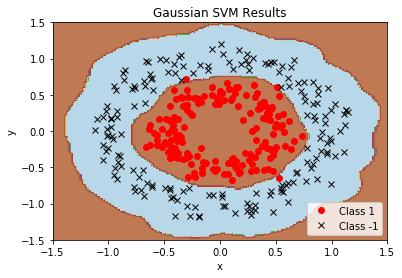

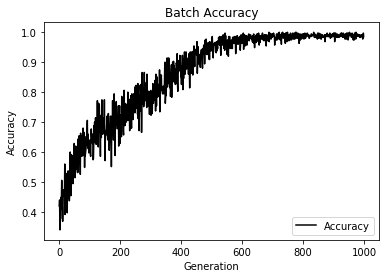

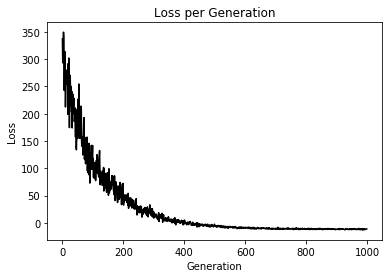

In [36]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

## Prediction/Evaluation

Here is code on how to predict the class on new or unseen data.

In [32]:
# New data points:
new_points = np.array([(-0.75, -0.75),
                       (-0.5, -0.5),
                       (-0.25, -0.25),
                       (0.25, 0.25),
                       (0.5, 0.5),
                       (0.75, 0.75)])

In [33]:
[evaluations] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                y_target: np.transpose([y_vals]),
                                                prediction_grid: new_points})

In [34]:
for ix, p in enumerate(new_points):
    print('{} : class={}'.format(p, evaluations[ix]))

[-0.75 -0.75] : class=-1.0
[-0.5 -0.5] : class=1.0
[-0.25 -0.25] : class=1.0
[0.25 0.25] : class=1.0
[0.5 0.5] : class=1.0
[0.75 0.75] : class=-1.0
